In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Dec 29 09:42:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   40C    P8    40W / 250W |    891MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '29December_Tracks_to_Hists_Iteration_2A_100epochs_lr_1em7_2p5_kde2hists_allFloat'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 1e-7

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_A as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
## training_t2hists_A.py increases "difference" for accepting found
## peaks as matched from 5 bins to 7.5 bins (compmared to original training.py)
from model.training_t2hists_A import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 25.59 s
outer loop X.shape =  (20000, 9, 600)
Constructing 18000 event dataset took 0.2608 s
x_t.shape =  torch.Size([18000, 9, 600])
x_t.shape[0] =  18000
x_t.shape[1] =  9
x_t.shape =  torch.Size([18000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 0) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [12]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
'''
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''


'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''

'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()
'''

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder = '29December_Tracks_to_Hists_First_Iteration_10epochs_lr_1em7_2p5_kde2hists_allFloat'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_t2hists_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


<All keys matched successfully>

In [13]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [14]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


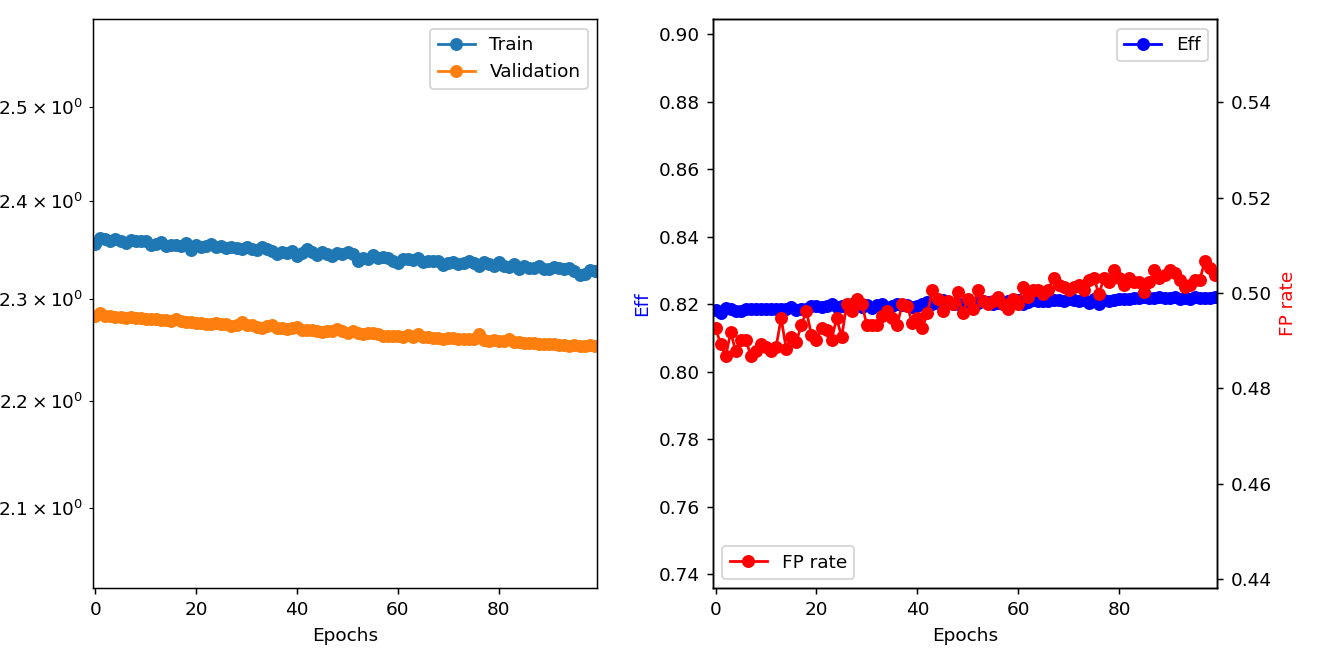

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1125, val = 125


Epoch 0: train=2.35549, val=2.28341, took 43.683 s
  Validation Found 8854 of 10819, added 986 (eff 81.84%) (0.493 FP/event)


Epoch 1: train=2.36141, val=2.28608, took 43.655 s
  Validation Found 8845 of 10819, added 979 (eff 81.75%) (0.489 FP/event)


Epoch 2: train=2.36081, val=2.28263, took 43.202 s
  Validation Found 8861 of 10819, added 974 (eff 81.90%) (0.487 FP/event)


Epoch 3: train=2.35882, val=2.28296, took 43.531 s
  Validation Found 8855 of 10819, added 984 (eff 81.85%) (0.492 FP/event)


Epoch 4: train=2.36113, val=2.28225, took 43.654 s
  Validation Found 8849 of 10819, added 976 (eff 81.79%) (0.488 FP/event)


Epoch 5: train=2.35882, val=2.28171, took 43.844 s
  Validation Found 8850 of 10819, added 981 (eff 81.80%) (0.49 FP/event)


Epoch 6: train=2.35663, val=2.28115, took 44.08 s
  Validation Found 8855 of 10819, added 981 (eff 81.85%) (0.49 FP/event)


Epoch 7: train=2.35927, val=2.28168, took 43.786 s
  Validation Found 8857 of 10819, added 974 (eff 81.87%) (0.487 FP/event)


Epoch 8: train=2.35854, val=2.28055, took 44.234 s
  Validation Found 8856 of 10819, added 976 (eff 81.86%) (0.488 FP/event)


Epoch 9: train=2.3588, val=2.28099, took 44.064 s
  Validation Found 8856 of 10819, added 979 (eff 81.86%) (0.489 FP/event)


Epoch 10: train=2.3589, val=2.27995, took 43.988 s
  Validation Found 8857 of 10819, added 978 (eff 81.87%) (0.489 FP/event)


Epoch 11: train=2.35409, val=2.28031, took 43.894 s
  Validation Found 8856 of 10819, added 976 (eff 81.86%) (0.488 FP/event)


Epoch 12: train=2.35518, val=2.28, took 44.365 s
  Validation Found 8857 of 10819, added 978 (eff 81.87%) (0.489 FP/event)


Epoch 13: train=2.35737, val=2.27875, took 43.925 s
  Validation Found 8856 of 10819, added 990 (eff 81.86%) (0.495 FP/event)


Epoch 14: train=2.35385, val=2.2785, took 44.104 s
  Validation Found 8855 of 10819, added 977 (eff 81.85%) (0.488 FP/event)


Epoch 15: train=2.35423, val=2.27793, took 44.008 s
  Validation Found 8863 of 10819, added 982 (eff 81.92%) (0.491 FP/event)


Epoch 16: train=2.35457, val=2.2802, took 44.012 s
  Validation Found 8854 of 10819, added 980 (eff 81.84%) (0.49 FP/event)


Epoch 17: train=2.35316, val=2.27802, took 43.791 s
  Validation Found 8858 of 10819, added 987 (eff 81.87%) (0.493 FP/event)


Epoch 18: train=2.35633, val=2.27721, took 43.707 s
  Validation Found 8858 of 10819, added 993 (eff 81.87%) (0.496 FP/event)


Epoch 19: train=2.34997, val=2.27695, took 43.717 s
  Validation Found 8867 of 10819, added 983 (eff 81.96%) (0.491 FP/event)


Epoch 20: train=2.35458, val=2.27642, took 43.696 s
  Validation Found 8866 of 10819, added 981 (eff 81.95%) (0.49 FP/event)


Epoch 21: train=2.35279, val=2.2756, took 43.682 s
  Validation Found 8864 of 10819, added 986 (eff 81.93%) (0.493 FP/event)


Epoch 22: train=2.35358, val=2.27507, took 43.885 s
  Validation Found 8865 of 10819, added 985 (eff 81.94%) (0.492 FP/event)


Epoch 23: train=2.35512, val=2.27539, took 43.758 s
  Validation Found 8872 of 10819, added 981 (eff 82.00%) (0.49 FP/event)


Epoch 24: train=2.35229, val=2.27569, took 43.618 s
  Validation Found 8863 of 10819, added 990 (eff 81.92%) (0.495 FP/event)


Epoch 25: train=2.35377, val=2.27549, took 43.709 s
  Validation Found 8867 of 10819, added 982 (eff 81.96%) (0.491 FP/event)


Epoch 26: train=2.35108, val=2.27493, took 44.253 s
  Validation Found 8863 of 10819, added 996 (eff 81.92%) (0.498 FP/event)


Epoch 27: train=2.35222, val=2.27337, took 43.711 s
  Validation Found 8872 of 10819, added 993 (eff 82.00%) (0.496 FP/event)


Epoch 28: train=2.35146, val=2.27357, took 43.834 s
  Validation Found 8870 of 10819, added 998 (eff 81.99%) (0.499 FP/event)


Epoch 29: train=2.35009, val=2.2771, took 43.786 s
  Validation Found 8864 of 10819, added 996 (eff 81.93%) (0.498 FP/event)


Epoch 30: train=2.35206, val=2.27439, took 43.671 s
  Validation Found 8870 of 10819, added 987 (eff 81.99%) (0.493 FP/event)


Epoch 31: train=2.35011, val=2.27451, took 43.518 s
  Validation Found 8861 of 10819, added 987 (eff 81.90%) (0.493 FP/event)


Epoch 32: train=2.34977, val=2.272, took 43.911 s
  Validation Found 8870 of 10819, added 987 (eff 81.99%) (0.493 FP/event)


Epoch 33: train=2.35241, val=2.27143, took 43.923 s
  Validation Found 8872 of 10819, added 991 (eff 82.00%) (0.495 FP/event)


Epoch 34: train=2.35005, val=2.27318, took 43.838 s
  Validation Found 8854 of 10819, added 993 (eff 81.84%) (0.496 FP/event)


Epoch 35: train=2.34873, val=2.27365, took 43.815 s
  Validation Found 8867 of 10819, added 990 (eff 81.96%) (0.495 FP/event)


Epoch 36: train=2.34582, val=2.27077, took 44.013 s
  Validation Found 8872 of 10819, added 987 (eff 82.00%) (0.493 FP/event)


Epoch 37: train=2.34705, val=2.27104, took 43.677 s
  Validation Found 8869 of 10819, added 996 (eff 81.98%) (0.498 FP/event)


Epoch 38: train=2.34623, val=2.27013, took 43.622 s
  Validation Found 8870 of 10819, added 995 (eff 81.99%) (0.497 FP/event)


Epoch 39: train=2.34808, val=2.27111, took 43.937 s
  Validation Found 8864 of 10819, added 988 (eff 81.93%) (0.494 FP/event)


Epoch 40: train=2.34336, val=2.27158, took 43.769 s
  Validation Found 8865 of 10819, added 990 (eff 81.94%) (0.495 FP/event)


Epoch 41: train=2.3467, val=2.26927, took 43.766 s
  Validation Found 8872 of 10819, added 986 (eff 82.00%) (0.493 FP/event)


Epoch 42: train=2.35008, val=2.26885, took 43.679 s
  Validation Found 8879 of 10819, added 992 (eff 82.07%) (0.496 FP/event)


Epoch 43: train=2.34777, val=2.26895, took 43.707 s
  Validation Found 8873 of 10819, added 1002 (eff 82.01%) (0.501 FP/event)


Epoch 44: train=2.34396, val=2.26822, took 43.67 s
  Validation Found 8877 of 10819, added 998 (eff 82.05%) (0.499 FP/event)


Epoch 45: train=2.34702, val=2.26731, took 43.805 s
  Validation Found 8884 of 10819, added 993 (eff 82.11%) (0.496 FP/event)


Epoch 46: train=2.34553, val=2.26798, took 43.703 s
  Validation Found 8877 of 10819, added 997 (eff 82.05%) (0.498 FP/event)


Epoch 47: train=2.34331, val=2.26784, took 43.663 s
  Validation Found 8873 of 10819, added 996 (eff 82.01%) (0.498 FP/event)


Epoch 48: train=2.34648, val=2.26964, took 43.972 s
  Validation Found 8874 of 10819, added 1001 (eff 82.02%) (0.5 FP/event)


Epoch 49: train=2.34526, val=2.26845, took 43.522 s
  Validation Found 8874 of 10819, added 992 (eff 82.02%) (0.496 FP/event)


Epoch 50: train=2.34722, val=2.2666, took 43.6 s
  Validation Found 8872 of 10819, added 998 (eff 82.00%) (0.499 FP/event)


Epoch 51: train=2.34539, val=2.26801, took 43.682 s
  Validation Found 8877 of 10819, added 994 (eff 82.05%) (0.497 FP/event)


Epoch 52: train=2.33828, val=2.26588, took 43.887 s
  Validation Found 8875 of 10819, added 1002 (eff 82.03%) (0.501 FP/event)


Epoch 53: train=2.3414, val=2.26529, took 43.759 s
  Validation Found 8882 of 10819, added 997 (eff 82.10%) (0.498 FP/event)


Epoch 54: train=2.33987, val=2.26565, took 43.671 s
  Validation Found 8879 of 10819, added 996 (eff 82.07%) (0.498 FP/event)


Epoch 55: train=2.34412, val=2.26603, took 43.903 s
  Validation Found 8874 of 10819, added 997 (eff 82.02%) (0.498 FP/event)


Epoch 56: train=2.34112, val=2.26525, took 43.852 s
  Validation Found 8876 of 10819, added 999 (eff 82.04%) (0.499 FP/event)


Epoch 57: train=2.34232, val=2.26363, took 43.898 s
  Validation Found 8874 of 10819, added 996 (eff 82.02%) (0.498 FP/event)


Epoch 58: train=2.34177, val=2.26303, took 43.739 s
  Validation Found 8882 of 10819, added 994 (eff 82.10%) (0.497 FP/event)


Epoch 59: train=2.33827, val=2.26303, took 43.612 s
  Validation Found 8879 of 10819, added 998 (eff 82.07%) (0.499 FP/event)


Epoch 60: train=2.33642, val=2.26364, took 43.634 s
  Validation Found 8885 of 10819, added 996 (eff 82.12%) (0.498 FP/event)


Epoch 61: train=2.34029, val=2.26263, took 43.567 s
  Validation Found 8873 of 10819, added 1003 (eff 82.01%) (0.501 FP/event)


Epoch 62: train=2.34011, val=2.26394, took 43.645 s
  Validation Found 8880 of 10819, added 999 (eff 82.08%) (0.499 FP/event)


Epoch 63: train=2.33966, val=2.26214, took 43.792 s
  Validation Found 8886 of 10819, added 1002 (eff 82.13%) (0.501 FP/event)


Epoch 64: train=2.34096, val=2.26496, took 43.868 s
  Validation Found 8881 of 10819, added 1002 (eff 82.09%) (0.501 FP/event)


Epoch 65: train=2.33718, val=2.26175, took 43.905 s
  Validation Found 8882 of 10819, added 1000 (eff 82.10%) (0.5 FP/event)


Epoch 66: train=2.33834, val=2.26184, took 43.804 s
  Validation Found 8883 of 10819, added 1002 (eff 82.11%) (0.501 FP/event)


Epoch 67: train=2.33792, val=2.26102, took 43.691 s
  Validation Found 8884 of 10819, added 1007 (eff 82.11%) (0.503 FP/event)


Epoch 68: train=2.33805, val=2.26133, took 43.95 s
  Validation Found 8885 of 10819, added 1004 (eff 82.12%) (0.502 FP/event)


Epoch 69: train=2.33387, val=2.26064, took 43.917 s
  Validation Found 8881 of 10819, added 1003 (eff 82.09%) (0.501 FP/event)


Epoch 70: train=2.33625, val=2.26145, took 43.75 s
  Validation Found 8889 of 10819, added 1002 (eff 82.16%) (0.501 FP/event)


Epoch 71: train=2.33745, val=2.26136, took 43.906 s
  Validation Found 8886 of 10819, added 1003 (eff 82.13%) (0.501 FP/event)


Epoch 72: train=2.33542, val=2.26054, took 43.724 s
  Validation Found 8881 of 10819, added 1004 (eff 82.09%) (0.502 FP/event)


Epoch 73: train=2.33629, val=2.26042, took 43.809 s
  Validation Found 8885 of 10819, added 1002 (eff 82.12%) (0.501 FP/event)


Epoch 74: train=2.33864, val=2.25998, took 43.772 s
  Validation Found 8876 of 10819, added 1006 (eff 82.04%) (0.503 FP/event)


Epoch 75: train=2.33588, val=2.25995, took 43.637 s
  Validation Found 8889 of 10819, added 1007 (eff 82.16%) (0.503 FP/event)


Epoch 76: train=2.3328, val=2.26509, took 43.675 s
  Validation Found 8872 of 10819, added 1000 (eff 82.00%) (0.5 FP/event)


Epoch 77: train=2.33697, val=2.25886, took 43.793 s
  Validation Found 8885 of 10819, added 1007 (eff 82.12%) (0.503 FP/event)


Epoch 78: train=2.33494, val=2.25843, took 43.846 s
  Validation Found 8883 of 10819, added 1005 (eff 82.11%) (0.502 FP/event)


Epoch 79: train=2.33304, val=2.25918, took 43.96 s
  Validation Found 8884 of 10819, added 1010 (eff 82.11%) (0.505 FP/event)


Epoch 80: train=2.33738, val=2.25792, took 43.936 s
  Validation Found 8887 of 10819, added 1007 (eff 82.14%) (0.503 FP/event)


Epoch 81: train=2.33305, val=2.25811, took 44.177 s
  Validation Found 8888 of 10819, added 1004 (eff 82.15%) (0.502 FP/event)


Epoch 82: train=2.33251, val=2.26037, took 43.69 s
  Validation Found 8889 of 10819, added 1007 (eff 82.16%) (0.503 FP/event)


Epoch 83: train=2.3351, val=2.25775, took 43.737 s
  Validation Found 8892 of 10819, added 1005 (eff 82.19%) (0.502 FP/event)


Epoch 84: train=2.3298, val=2.25713, took 43.622 s
  Validation Found 8892 of 10819, added 1005 (eff 82.19%) (0.502 FP/event)


Epoch 85: train=2.33365, val=2.2563, took 43.768 s
  Validation Found 8895 of 10819, added 1001 (eff 82.22%) (0.5 FP/event)


Epoch 86: train=2.33083, val=2.25582, took 43.492 s
  Validation Found 8891 of 10819, added 1005 (eff 82.18%) (0.502 FP/event)


Epoch 87: train=2.33118, val=2.25599, took 43.581 s
  Validation Found 8892 of 10819, added 1010 (eff 82.19%) (0.505 FP/event)


Epoch 88: train=2.33312, val=2.25527, took 43.767 s
  Validation Found 8896 of 10819, added 1007 (eff 82.23%) (0.503 FP/event)


Epoch 89: train=2.32971, val=2.2549, took 43.828 s
  Validation Found 8893 of 10819, added 1008 (eff 82.20%) (0.504 FP/event)


Epoch 90: train=2.32993, val=2.25501, took 44.068 s
  Validation Found 8891 of 10819, added 1010 (eff 82.18%) (0.505 FP/event)


Epoch 91: train=2.33185, val=2.25543, took 43.605 s
  Validation Found 8896 of 10819, added 1009 (eff 82.23%) (0.504 FP/event)


Epoch 92: train=2.33162, val=2.25436, took 43.78 s
  Validation Found 8890 of 10819, added 1006 (eff 82.17%) (0.503 FP/event)


Epoch 93: train=2.33023, val=2.25426, took 43.512 s
  Validation Found 8893 of 10819, added 1003 (eff 82.20%) (0.501 FP/event)


Epoch 94: train=2.33065, val=2.25377, took 44.315 s
  Validation Found 8888 of 10819, added 1004 (eff 82.15%) (0.502 FP/event)


Epoch 95: train=2.32791, val=2.25388, took 43.723 s
  Validation Found 8894 of 10819, added 1006 (eff 82.21%) (0.503 FP/event)


Epoch 96: train=2.32424, val=2.25336, took 43.702 s
  Validation Found 8892 of 10819, added 1006 (eff 82.19%) (0.503 FP/event)


Epoch 97: train=2.32495, val=2.25318, took 43.692 s
  Validation Found 8892 of 10819, added 1014 (eff 82.19%) (0.507 FP/event)


Epoch 98: train=2.32962, val=2.25389, took 43.653 s
  Validation Found 8893 of 10819, added 1011 (eff 82.20%) (0.505 FP/event)


Epoch 99: train=2.32852, val=2.25363, took 43.819 s
  Validation Found 8894 of 10819, added 1008 (eff 82.21%) (0.504 FP/event)



In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


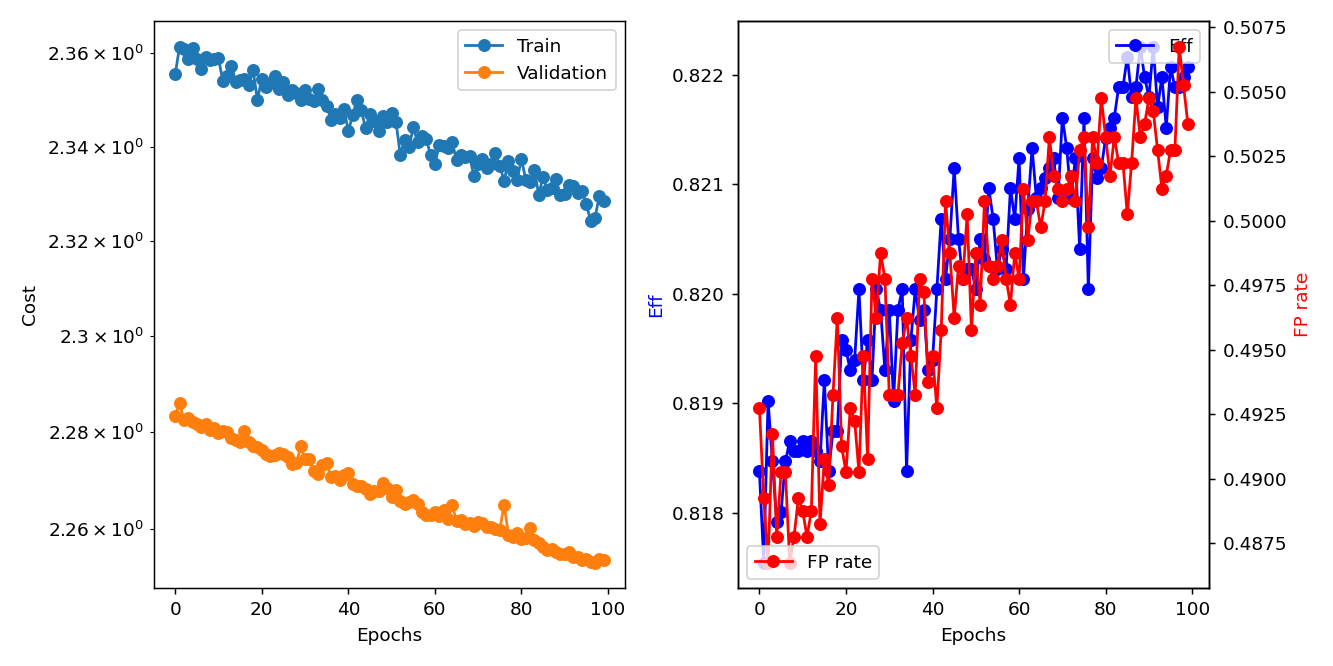

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [1]:
##quit()

